# Histopathologic Cancer Detection - Mini Project

This Jupyter Notebook is part of the Histopathologic Cancer Detection project. It is designed to explore, preprocess, and analyze histopathologic image data, as well as to train and evaluate a deep learning model for cancer detection.

**Key Sections:**

1- **Data Loading and Exploration:**

- Load histopathologic image datasets.
- Visualize sample images and analyze class distributions.

2- **Data Preprocessing:**

- Resize and normalize images.
- Apply data augmentation techniques to improve model generalization.

3- **Model Development:**

- Define and build a deep learning model using frameworks like TensorFlow or PyTorch.
- Configure the model architecture, including layers, activation functions, and optimizers.

4- **Training and Validation:**

- Train the model on the preprocessed dataset.
- Monitor performance metrics such as accuracy and loss during training.

5- **Evaluation:**

- Evaluate the model on a test dataset.
- Generate performance metrics (e.g., confusion matrix, precision, recall, F1-score).

6- **Kaggle results:**

- Predict the test generator.
- Present the kaggle result of the competition.

7- **Conclusion:**

- Summarize findings and discuss potential improvements.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

## Data Loading and Exploration

In this section, we focus on loading the histopathologic image dataset and performing an initial exploration of the data. The goal is to understand the structure and distribution of the dataset, which is crucial for designing an effective preprocessing and modeling pipeline.

**Key steps include:**

- Loading the dataset into memory, ensuring proper file paths and formats.
- Visualizing sample images to gain insights into the data characteristics.
- Analyzing class distributions to identify potential imbalances that may affect model performance.

This exploration provides a foundation for the subsequent preprocessing and modeling stages.

Image Shape = (96, 96, 3)


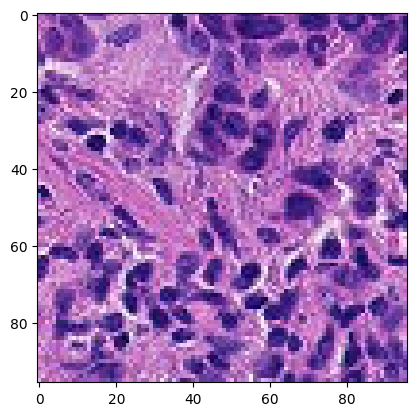

In [3]:
example_path = '../data/histopathologic-cancer-detection/train/0000da768d06b879e5754c43e2298ce48726f722.tif'
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

In [4]:
TRAIN_PATH = "../data/histopathologic-cancer-detection/train"
TEST_PATH = "../data/histopathologic-cancer-detection/test"

In [5]:
def train_img_path(id_str):
    return os.path.join(TRAIN_PATH, f"{id_str}.tif")

In [6]:
train_labels_df = pd.read_csv('../data/histopathologic-cancer-detection/train_labels.csv')
train_labels_df["filename"] = train_labels_df["id"].apply(train_img_path)
train_labels_df["label"] = train_labels_df["label"].astype(str)
train_labels_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,../data/histopathologic-cancer-detection/train...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,../data/histopathologic-cancer-detection/train...
2,755db6279dae599ebb4d39a9123cce439965282d,0,../data/histopathologic-cancer-detection/train...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,../data/histopathologic-cancer-detection/train...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,../data/histopathologic-cancer-detection/train...


In [7]:
train_labels_df.shape

(220025, 3)

In [8]:
count_label = train_labels_df.groupby('label')['id'].count().reset_index().rename(columns={'id':'count'})

<Figure size 1500x700 with 0 Axes>

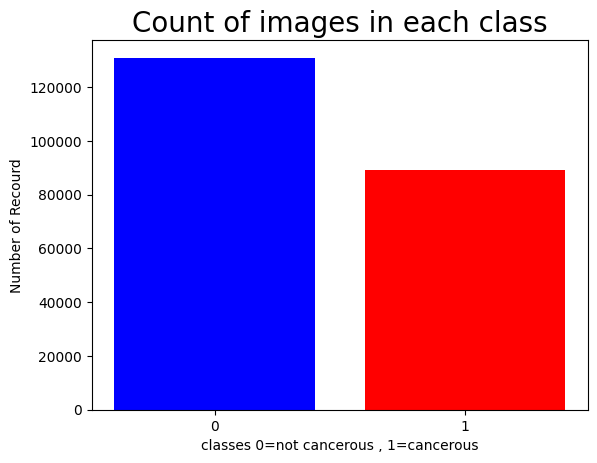

In [9]:
plt.figure(figsize=(15,7))
fig, ax = plt.subplots()
ax.bar(count_label['label'], count_label['count'], color=['blue','red'])

plt.xlabel('classes 0=not cancerous , 1=cancerous')
plt.ylabel('Number of Recourd')
plt.title('Count of images in each class', fontsize=20)
plt.show()

In [10]:
train_labels_df['label'].value_counts(normalize = True)

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

In [11]:
sample_data = np.empty((100, 96, 96, 3), dtype=np.uint8)
sample_labels = np.empty(100, dtype=np.int8)
for i in range(len(train_labels_df))[:100]:
    img_path = train_img_path(train_labels_df['id'][i])
    img = Image.open(img_path)
    sample_data[i] = np.array(img)
    sample_labels[i] = train_labels_df['label'][i]

Non-Cancerous Images


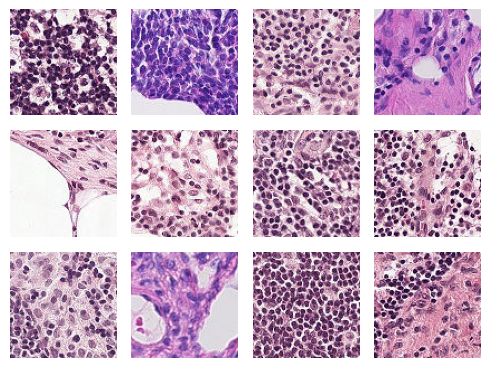

In [12]:
print("Non-Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 0].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 0][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

Cancerous Images


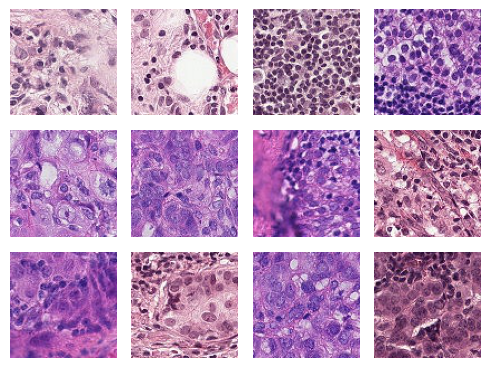

In [13]:
print("Cancerous Images")

selected_images = np.random.choice(sample_data[sample_labels == 1].shape[0], 12, replace=False)
grid_size = int(np.ceil(np.sqrt(12)))

fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axs.flatten()):
    if i < 12:
        ax.imshow(sample_data[sample_labels == 1][selected_images[i]])
        ax.axis('off') 
    else:
        fig.delaxes(ax) 

plt.tight_layout()
plt.show()

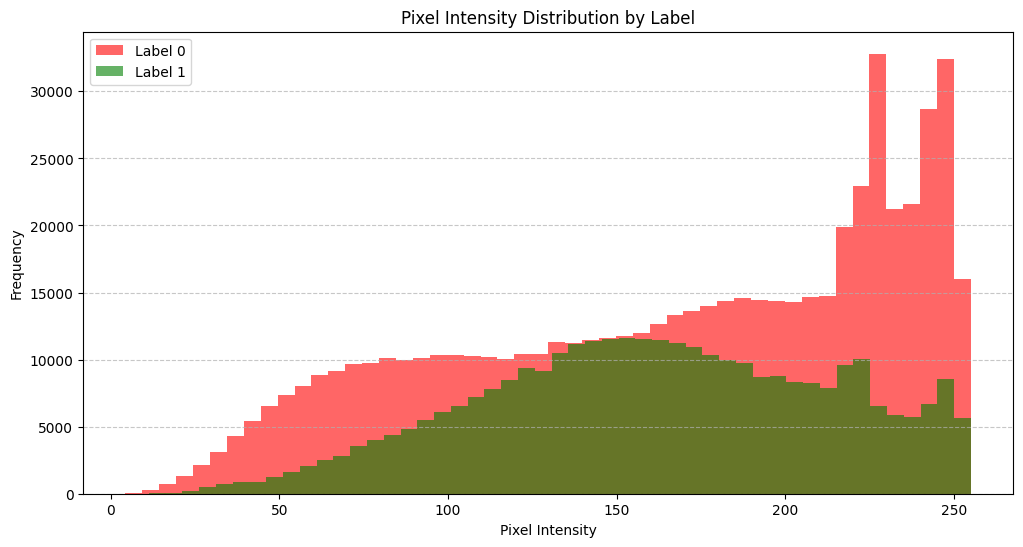

In [18]:
# Separate pixel values for label=0 and label=1
pixel_values_label_0 = []
pixel_values_label_1 = []

# Iterate through the dataset and collect pixel values based on labels
for image_, label in zip(sample_data, sample_labels):
    # Convert the RGB image (96, 96, 3) to grayscale
    grayscale_image = np.mean(image_, axis=2)  # Average across the color channels to get grayscale
    if label == 0:
        pixel_values_label_0.extend(grayscale_image.flatten())  # Collect pixel values for label=0
    elif label == 1:
        pixel_values_label_1.extend(grayscale_image.flatten())  # Collect pixel values for label=1

# Plot the pixel intensity distribution for both labels
plt.figure(figsize=(12, 6))

# Distribution for label=0
plt.hist(pixel_values_label_0, bins=50, color='red', alpha=0.6, label='Label 0')

# Distribution for label=1
plt.hist(pixel_values_label_1, bins=50, color='green', alpha=0.6, label='Label 1')

plt.title('Pixel Intensity Distribution by Label')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Data Preprocessing:

In this section, we prepare the histopathologic image dataset for training the deep learning model. Proper preprocessing is essential to ensure the model performs well and generalizes effectively to unseen data.

In [27]:
test_ids = [filename[:-4] for filename in os.listdir(TEST_PATH)]
test_filenames = [os.path.join(TEST_PATH, filename) for filename in os.listdir(TEST_PATH)]
test_df = pd.DataFrame()
test_df['id'] = test_ids
test_df['filename'] = test_filenames

In [28]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

train_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96,96),
    color_mode='rgb',
    batch_size = 32,
    class_mode = 'binary',
    subset = 'training',
    validate_filenames = False,
    seed = 123

)

validation_generator = datagen.flow_from_dataframe(
    shuffle = True,
    dataframe = train_labels_df,
    x_col = 'filename',
    y_col = 'label',
    target_size = (96,96),
    color_mode='rgb',
    batch_size = 32,
    class_mode = 'binary',
    subset = 'validation',
    validate_filenames = False,
    seed = 123 
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col = "filename",
    y_col = None,
    target_size = (96, 96),
    color_mode = "rgb",
    batch_size = 32,
    shuffle = False,
    class_mode = None,
    validate_filenames = False,
    seed = 123
)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.
Found 57458 non-validated image filenames.


## Model Development

In this section, we focus on designing and building a deep learning model to detect cancerous tissue in histopathologic images. The goal is to create a model architecture that can effectively learn patterns from the dataset and make accurate predictions.

**Key steps include:**

- **Defining the Model Architecture:** Selecting and configuring layers such as convolutional layers, pooling layers, and fully connected layers to extract features and classify images.
- **Choosing Activation Functions:** Using activation functions like ReLU and softmax to introduce non-linearity and output probabilities for classification.
- **Configuring the Optimizer and Loss Function:** Selecting an appropriate optimizer (e.g., Adam) and loss function (e.g., binary cross-entropy) to guide the training process.

This section lays the groundwork for training and evaluating the model, ensuring it is well-suited for the task of cancer detection.

In [30]:
# VGGNet

def conv_pool_layer(n_conv,model_input):
    for i in range(n_conv):
        x = tf.keras.layers.Conv2D(filters=50,
                               kernel_size=(3,3),
                               strides=2,
                               padding='same',
                               activation='relu')(model_input)
    x = tf.keras.layers.MaxPool2D(
        pool_size=(2,2),
        strides=None,
        padding='same'
    )(x)
    return x

def VGGNet(input_shape=(96,96,3)):
    # Define the input as a tensor
    X_input = tf.keras.layers.Input(input_shape)
    # Hidden layers
    x = tf.keras.layers.Conv2D(filters=100,
                               kernel_size=(3,3),
                               strides=1,
                               padding='same',
                               activation='relu')(X_input)
    x = conv_pool_layer(n_conv=2,model_input=x)
    x = conv_pool_layer(n_conv=2,model_input=x)
    x = conv_pool_layer(n_conv=3,model_input=x)
    x = conv_pool_layer(n_conv=3,model_input=x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    # Output Layer
    output = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    # Create model
    model = tf.keras.models.Model(inputs = X_input, outputs = output)
    return model

model = VGGNet()
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 100)    │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 50)     │        45,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 50)     │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 50)       │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 1, 1, 50)       │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758,317 (2.89 MB)

 Trainable params: 758,317 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred, beta=1):
    y_pred = tf.math.sigmoid(y_pred)
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + K.epsilon())
    return K.mean(f1)

In [32]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC(), f1_score],
              )

In [33]:
steps_per_epoch = len(train_generator) 

In [34]:
val_steps_per_epoch = len(validation_generator)

## Training and Validation:

In this section, we train the deep learning model on the preprocessed dataset and validate its performance. The goal is to optimize the model's parameters to minimize the loss function and improve accuracy while monitoring its performance on a validation set to prevent overfitting.

**Key steps include:**

- **Training the Model:** Feeding the training data into the model in batches, performing forward and backward passes, and updating weights using the optimizer.
- **Validation:** Evaluating the model on a separate validation set after each epoch to monitor its generalization performance.
- **Performance Metrics:** Tracking metrics such as accuracy, loss, and validation accuracy to assess the model's progress and identify potential issues like overfitting or underfitting.

This section ensures the model is effectively trained and validated, preparing it for evaluation on unseen test data.

In [36]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator,
    validation_steps = val_steps_per_epoch,
    epochs = 15
)

Epoch 1/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 971s 177ms/step - accuracy: 0.8925 - auc: 0.9556 - f1_score: 0.3037 - loss: 0.2631 - val_accuracy: 0.8941 - val_auc: 0.9618 - val_f1_score: 0.3057 - val_loss: 0.2573
Epoch 2/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 693s 126ms/step - accuracy: 0.9004 - auc: 0.9621 - f1_score: 0.3031 - loss: 0.2433 - val_accuracy: 0.9066 - val_auc: 0.9650 - val_f1_score: 0.3024 - val_loss: 0.2320
Epoch 3/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 730s 133ms/step - accuracy: 0.9104 - auc: 0.9684 - f1_score: 0.3051 - loss: 0.2221 - val_accuracy: 0.9100 - val_auc: 0.9668 - val_f1_score: 0.3033 - val_loss: 0.2276
Epoch 4/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 738s 134ms/step - accuracy: 0.9179 - auc: 0.9725 - f1_score: 0.3030 - loss: 0.2065 - val_accuracy: 0.9146 - val_auc: 0.9683 - val_f1_score: 0.3020 - val_loss: 0.2198
Epoch 5/15
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 748s 136ms/step - accuracy: 0.9247 - auc: 0.9758 - f1_score: 0.3043 - loss: 0.1930 - val_accuracy: 0.9037 - val_auc: 0.9714 - 

In [37]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)
    plt.figure(figsize=[14,4])
    n = int(len(h.keys()) / 2)
    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()
    plt.tight_layout()
    plt.show()

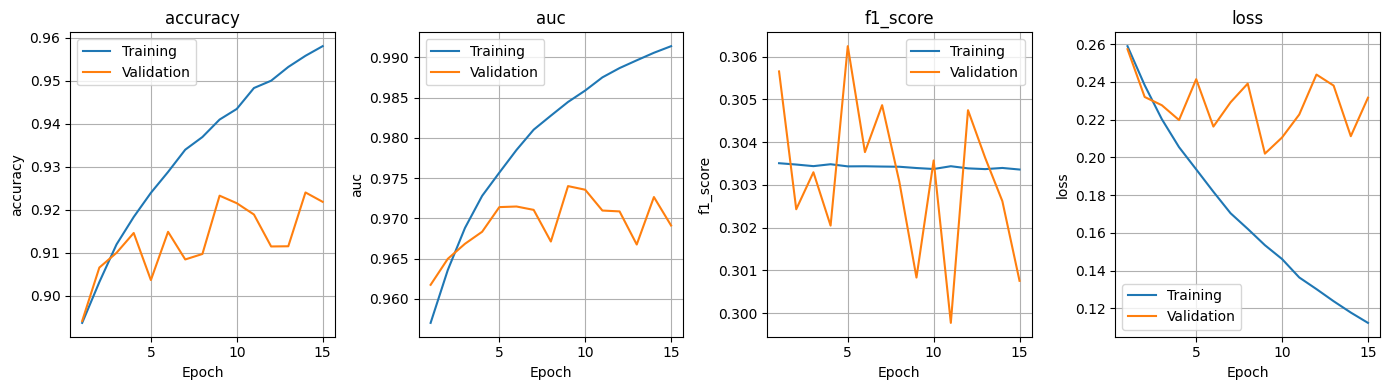

In [38]:
history_modelrestnet = merge_history([history])
vis_training(history_modelrestnet)

## Evaluation

In this section, we evaluate the performance of the trained deep learning model on a test dataset. The goal is to assess how well the model generalizes to unseen data and identify areas for improvement.

**Key steps include:**

- **Generating Predictions:** Using the trained model to predict labels for the test dataset.
- **Performance Metrics:** Calculating metrics such as accuracy, precision, recall, F1-score, and generating a confusion matrix to evaluate classification performance.
- **Insights:** Analyzing the results to understand the model's strengths and weaknesses.

In [22]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('../models/cnn_v1.h5', custom_objects={'f1_score': f1_score})

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61     26233
           1       0.41      0.39      0.40     17772

    accuracy                           0.53     44005
   macro avg       0.50      0.50      0.50     44005
weighted avg       0.52      0.53      0.52     44005



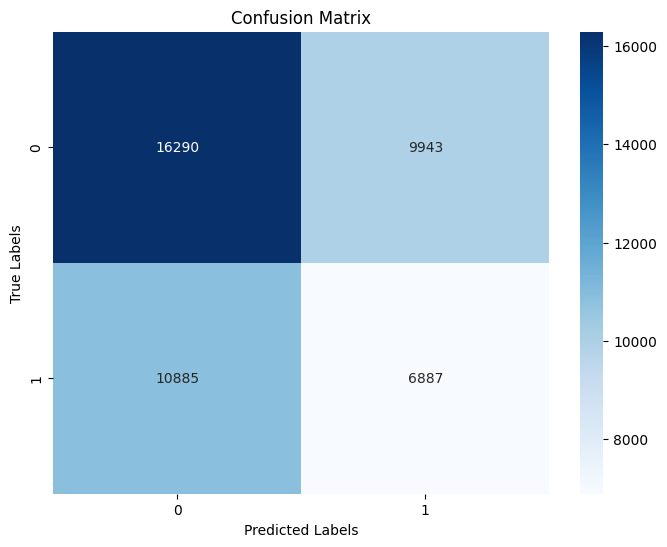

Accuracy: 0.53
Precision: 0.41
Recall: 0.39
F1 Score: 0.40


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the validation dataset
y_pred = model.predict(validation_generator)  # Predictions as probabilities
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes (for binary classification)

# Get true labels from the validation generator
test_labels = validation_generator.classes  # True labels
class_indices = validation_generator.class_indices  # Class-to-index mapping

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, y_pred_classes)
precision = precision_score(test_labels, y_pred_classes)
recall = recall_score(test_labels, y_pred_classes)
f1 = f1_score(test_labels, y_pred_classes)

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred_classes, target_names=list(class_indices.keys())))

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_indices.keys()), yticklabels=list(class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

## Kaggle results

In this section, we focus on generating predictions for the test dataset and preparing the submission file for the Kaggle competition. The goal is to evaluate the model's performance on the competition's test set and compare the results with other participants.

**Key steps include:**

- **Generating Predictions:** Using the trained model to predict labels for the test dataset provided by Kaggle.
- **Formatting the Submission File:** Preparing a CSV file in the required format for submission to the Kaggle platform.
- **Submitting Results:** Uploading the submission file to Kaggle and analyzing the leaderboard ranking.

This section highlights the final step of the project, where the model's performance is tested in a real-world competitive environment.


In [39]:
y_pred = model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 677s 377ms/step


In [40]:
y_pred

array([[9.7492480e-01],
       [9.5918179e-01],
       [1.8042390e-01],
       ...,
       [5.5915612e-04],
       [1.3807474e-01],
       [2.1328375e-01]], dtype=float32)

In [41]:
test_df['pred'] = y_pred.flatten()

In [42]:
test_df['label'] = test_df['pred'] >= 0.5
test_df['label'] = test_df['label'].astype(int)

In [43]:
test_df[['id','label']].sample(3)

,id,label
40026,b25117bfe9502530fc022ac4a708946e55f12b76,0
8836,27a59157c0f3b15933ae6b76921129d135d3c20a,0
9931,2c328a46d06213652c5717dceb79f962a8c0d7e9,0


In [44]:
test_df[['id','label']].to_csv('../data/submission.csv',index=None)

Image Shape = (1048, 1054, 4)


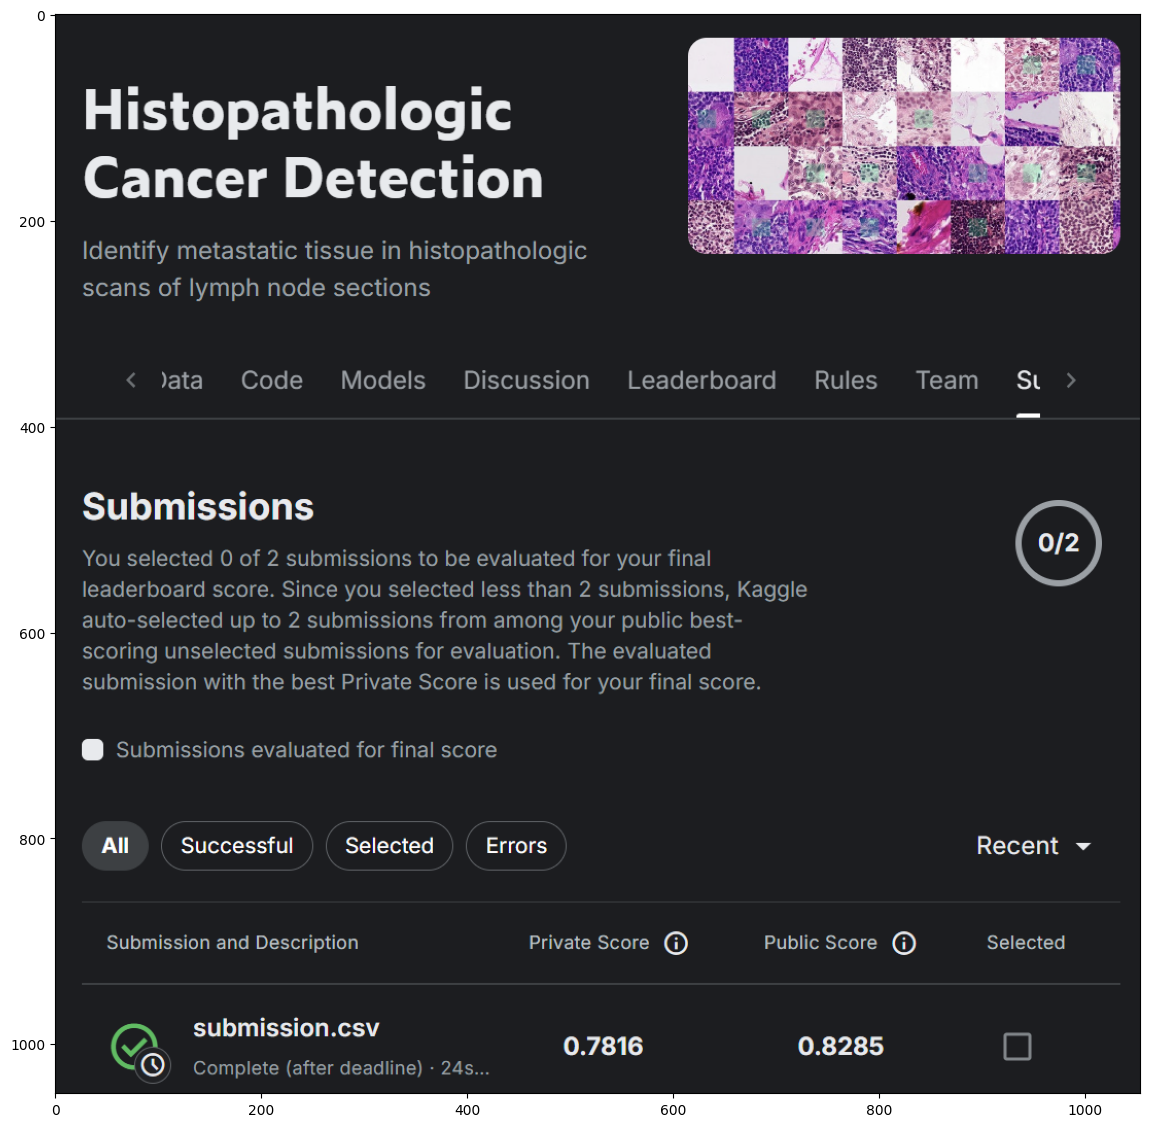

In [48]:
example_path = '../notebook/kaggle_score.png'
example_img = Image.open(example_path)
example_array = np.array(example_img)
plt.figure(figsize=[14,20])
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

In [ ]:
# Save model
model.save('../models/cnn_v1.keras')